In [1]:

from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/E_compressed.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/00016292_000.png  
  inflating: /content/images/00018944_003.png  
  inflating: /content/images/00010315_003.png  
  inflating: /content/images/00012152_000.png  
  inflating: /content/images/00015646_014.png  
  inflating: /content/images/00002772_000.png  
  inflating: /content/images/00008911_020.png  
  inflating: /content/images/00011237_049.png  
  inflating: /content/images/00029317_000.png  
  inflating: /content/images/00018371_001.png  
  inflating: /content/images/00025317_003.png  
  inflating: /content/images/00009730_001.png  
  inflating: /content/images/00028765_015.png  
  inflating: /content/images/00012672_003.png  
  inflating: /content/images/00009365_013.png  
  inflating: /content/images/00017947_016.png  
  inflating: /content/images/00029883_003.png  
  inflating: /content/images/00011020_000.png  
  inflating: /content/images/00012205_000.png  
  inflating: /content/images/00009166

In [2]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle


# Exploración de datos

In [3]:
df_selected = pd.read_csv("df_selected.csv")
df_selected.sample(5)

,Image_file,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
22075,00005845_000.png,5845,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6695,00001803_009.png,1803,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51313,00012963_000.png,12963,1,1,0,0,0,0,0,0,0,0,0,0,0,0
35430,00009349_010.png,9349,0,0,0,0,0,0,0,0,1,0,0,0,0,0
51402,00012989_002.png,12989,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Image_file          112120 non-null  object
 1   Patient ID          112120 non-null  int64 
 2   Atelectasis         112120 non-null  int64 
 3   Cardiomegaly        112120 non-null  int64 
 4   Consolidation       112120 non-null  int64 
 5   Edema               112120 non-null  int64 
 6   Effusion            112120 non-null  int64 
 7   Emphysema           112120 non-null  int64 
 8   Fibrosis            112120 non-null  int64 
 9   Hernia              112120 non-null  int64 
 10  Infiltration        112120 non-null  int64 
 11  Mass                112120 non-null  int64 
 12  Nodule              112120 non-null  int64 
 13  Pleural_Thickening  112120 non-null  int64 
 14  Pneumonia           112120 non-null  int64 
 15  Pneumothorax        112120 non-null  int64 
dtypes:

## Explorar etiquetas de datos y prevención de la fuga de datos:
Vale la pena señalar que nuestro conjunto de datos contiene varias imágenes para cada paciente. Este podría ser el caso, por ejemplo, cuando un paciente ha tomado varias imágenes de rayos X en diferentes momentos durante sus visitas al hospital. En nuestra división de datos, nos hemos asegurado de que la división se realice a nivel del paciente para que no haya "fugas" de datos entre los conjuntos de datos de entrenamiento, validación y prueba.

Para mejor visualizacion se creó una tabla con los nombres de cada enfermedad y su distribución, además se grafico la distribución para cada conjunto

Class Distribution per Dataset:
                    Train  Validation  Test
Atelectasis          8190        1692  1677
Cardiomegaly         1891         446   439
Consolidation        3228         709   730
Edema                1630         299   374
Effusion             9438        1987  1892
Emphysema            1666         396   454
Fibrosis             1156         259   271
Hernia                158          42    27
Infiltration        13868        3094  2932
Mass                 4260         795   727
Nodule               4432         954   945
Pleural_Thickening   2379         522   484
Pneumonia             995         222   214
Pneumothorax         3770         807   725


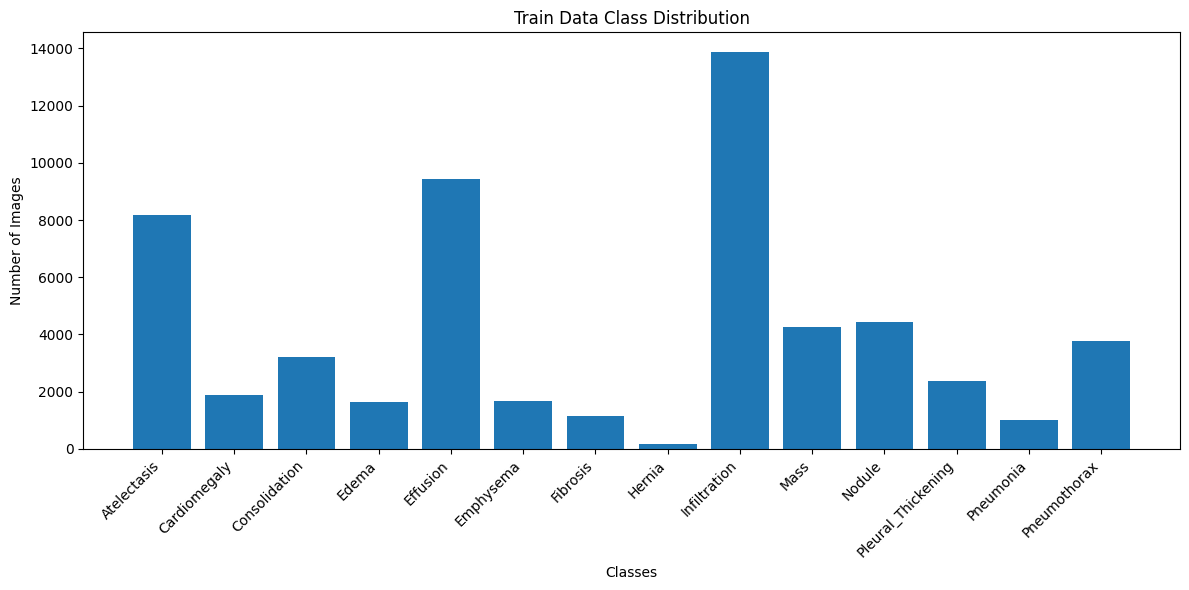

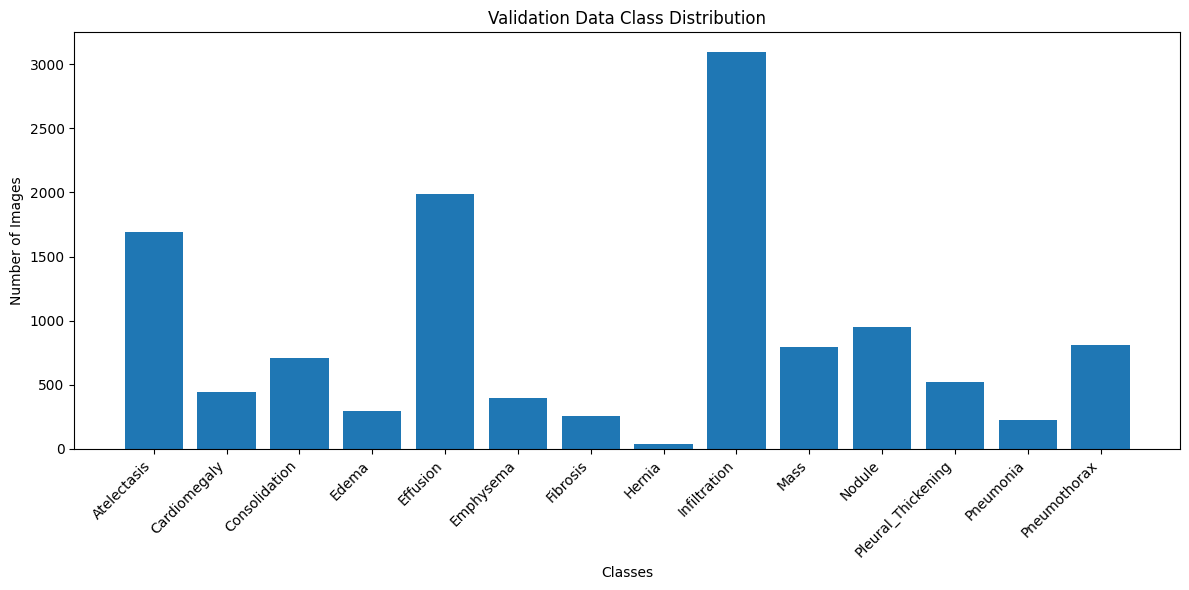

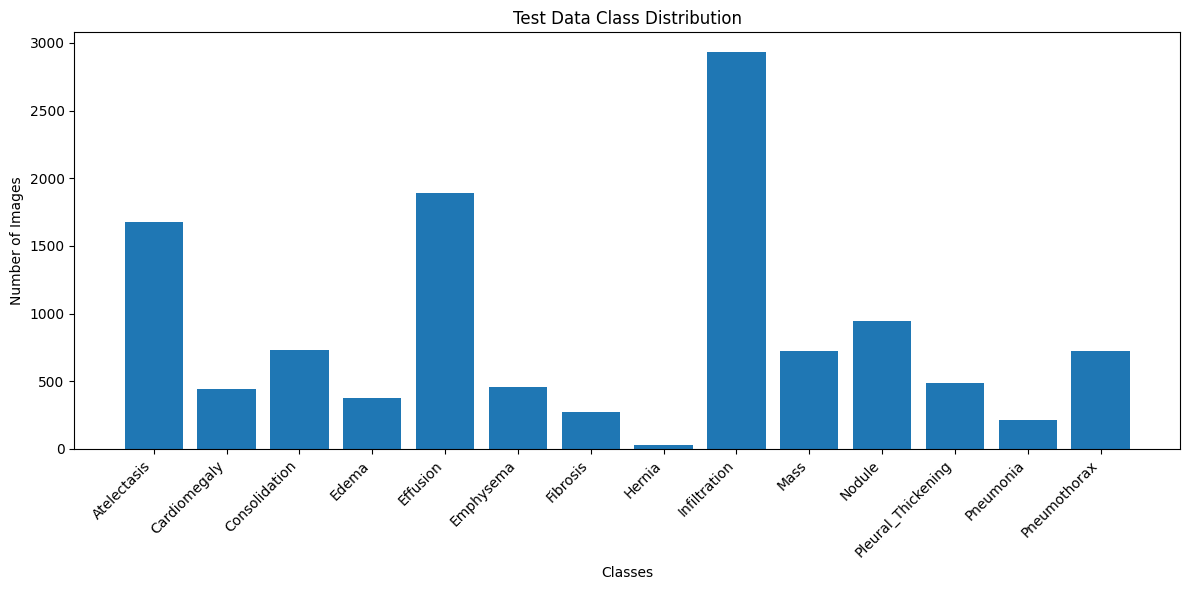

In [5]:
from sklearn.model_selection import train_test_split

# Get the list of classes
classes = [col for col in df_selected.columns if col not in ['Image_file', 'Patient ID']]

# Get unique patient IDs
patient_ids = df_selected['Patient ID'].unique()

# Split patient IDs into train, validation, and test sets
train_ids, test_val_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)


# Create dataframes for train, validation, and test sets based on patient IDs
train_df = df_selected[df_selected['Patient ID'].isin(train_ids)]
val_df = df_selected[df_selected['Patient ID'].isin(val_ids)]
test_df = df_selected[df_selected['Patient ID'].isin(test_ids)]

# Function to count class instances
def count_classes(df, classes):
  class_counts = {}
  for c in classes:
    class_counts[c] = df[c].sum()
  return class_counts

# Count classes in each dataset
train_counts = count_classes(train_df, classes)
val_counts = count_classes(val_df, classes)
test_counts = count_classes(test_df, classes)

# Create a summary dataframe
summary_data = {
    'Train': list(train_counts.values()),
    'Validation': list(val_counts.values()),
    'Test': list(test_counts.values())
}
summary_df = pd.DataFrame(summary_data, index=classes)

# Print the summary table
print("Class Distribution per Dataset:")
print(summary_df)

# Plotting function
def plot_class_distribution(counts, title):
    plt.figure(figsize=(12, 6))
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plotting the distributions
plot_class_distribution(train_counts, 'Train Data Class Distribution')
plot_class_distribution(val_counts, 'Validation Data Class Distribution')
plot_class_distribution(test_counts, 'Test Data Class Distribution')

In [6]:
train_df.head()

,Image_file,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [7]:
print(f"Conjunto de entrenamiento: la cantidad total de identificadores de pacientes son: {train_df['Patient ID'].count()}, de los cuales son identificadores únicos: {train_df['Patient ID'].value_counts().shape[0]} ")

Conjunto de entrenamiento: la cantidad total de identificadores de pacientes son: 78566, de los cuales son identificadores únicos: 21563 


In [8]:
def check_for_leakage(df1, df2, patient_col):

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])

    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0

    ### END CODE HERE ###

    return leakage

In [9]:
print("fuga entre el entrenamiento y la prueba: {}".format(check_for_leakage(train_df, test_df, 'Patient ID')))
print("fuga entre validación y prueba: {}".format(check_for_leakage(val_df, test_df, 'Patient ID')))

fuga entre el entrenamiento y la prueba: False
fuga entre validación y prueba: False


# Aumento de datos y submuestreo
Se aborda el desequilibrio de clases, buscando una distribución más equilibrada para mejorar el rendimiento del modelo.

Objetivo: alcanzar ~2000 imágenes por clase.
### Estrategia:
 1. Aumento de datos para clases minoritarias (<1700 imágenes):
- Se aplicaron transformaciones aleatorias (rotaciones, zoom, ruido) a imágenes de clases como 'Hernia', 'Pneumonia', 'Fibrosis', etc.
2. Submuestreo de clases mayoritarias:
- Se seleccionó un subconjunto aleatorio de imágenes, limitando el número a ~2000 imágenes por clase (±350 desviación).
3. Gestión de imágenes y DataFrame:
- Se actualizó `train_df` para reflejar los cambios (imágenes agregadas/eliminadas).
- Se eliminaron imágenes innecesarias del directorio.

### Beneficios esperados:
- Conjunto de datos más equilibrado.
- Mejor generalización y precisión del modelo, especialmente en clases minoritarias.
- Mayor rendimiento en la clasificación de imágenes médicas.

In [10]:
!pip install scikit-image

In [11]:
import os
import pandas as pd
import numpy as np
from skimage import io, transform
from skimage.util import random_noise
import shutil

# Define the target number of images per class and the allowed deviation
TARGET_IMAGES = 2000
DEVIATION = 250  # Updated deviation
img_dir = 'images'
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
          'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

# Function to augment an image with random transformations
def augment_image(image):
    # Random rotation
    angle = np.random.uniform(-20, 20)
    augmented_image = transform.rotate(image, angle, mode='reflect', preserve_range=True)

    # Random zoom
    zoom_factor = np.random.uniform(0.8, 1.2)
    augmented_image = transform.rescale(augmented_image, zoom_factor, mode='reflect', preserve_range=True, channel_axis=-1 if image.ndim == 3 else None)

    # Ensure zoomed image has the same shape as original (padding/cropping if necessary)
    if augmented_image.shape[:2] != image.shape[:2]:
        h_diff = augmented_image.shape[0] - image.shape[0]
        w_diff = augmented_image.shape[1] - image.shape[1]

        pad_h_top = max(0, -h_diff // 2)
        pad_h_bottom = max(0, -h_diff - pad_h_top)
        pad_w_left = max(0, -w_diff // 2)
        pad_w_right = max(0, -w_diff - pad_w_left)

        crop_h_start = max(0, h_diff // 2)
        crop_h_end = max(0, augmented_image.shape[0] - (h_diff + crop_h_start))

        augmented_image = augmented_image[crop_h_start:crop_h_end, pad_w_left:augmented_image.shape[1] - pad_w_right]

    # Random noise
    augmented_image = random_noise(augmented_image, mode='gaussian', var=0.01)

    augmented_image = (augmented_image * 255).astype(np.uint8)  # Convert to uint8
    return augmented_image

# Get class frequencies for all classes
class_counts = train_df[labels].sum(axis=0)

# Identify minority classes based on the 1700 threshold
minority_classes = class_counts[class_counts < 1700].index.tolist()
majority_classes = list(set(labels) - set(minority_classes))

# Initialize augmented dataframe
augmented_df = train_df.copy()

# Augment minority classes to reach TARGET_IMAGES with DEVIATION
for class_name in minority_classes:
    num_augment = max(0, TARGET_IMAGES - class_counts[class_name])
    class_df = train_df[train_df[class_name] == 1]

    for i in range(num_augment):
        sample_row = class_df.sample(1)
        image_path = os.path.join(img_dir, sample_row['Image_file'].values[0])
        image = io.imread(image_path)

        augmented_image = augment_image(image)

        new_filename = f"{sample_row['Image_file'].values[0].split('.')[0]}_aug_{i}.png"
        new_image_path = os.path.join(img_dir, new_filename)
        io.imsave(new_image_path, augmented_image)

        new_row = sample_row.copy()
        new_row['Image_file'] = new_filename

        train_df = pd.concat([train_df, new_row], ignore_index=True)
        augmented_df = pd.concat([augmented_df, new_row], ignore_index=True)

# Subsample majority classes to fit within TARGET_IMAGES +/- DEVIATION
for class_name in majority_classes:
    num_samples = min(class_counts[class_name], TARGET_IMAGES + DEVIATION)
    class_df = augmented_df[augmented_df[class_name] == 1]

    images_to_keep = class_df['Image_file'].sample(n=num_samples, random_state=42).tolist()

    augmented_df = augmented_df[augmented_df['Image_file'].isin(images_to_keep) | (augmented_df[class_name] == 0)]

# Update train_df
train_df = augmented_df

# Remove unnecessary images from the 'images' folder
all_images_in_df = train_df['Image_file'].tolist()
all_images_in_df.extend(val_df['Image_file'].tolist())
all_images_in_df.extend(test_df['Image_file'].tolist())

for filename in os.listdir(img_dir):
    if filename not in all_images_in_df:
        os.remove(os.path.join(img_dir, filename))


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: images/00000942_000_aug_225.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: images/00008885_007_aug_227.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: images/00009368_008_aug_228.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: images/00029817_004_aug_230.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: images/00008694_002_aug_231.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: images/00009368_

In [12]:
class_counts = train_df[labels].sum(axis=0)

# Crear un DataFrame para mostrar los resultados
class_counts_df = pd.DataFrame({'Clase': class_counts.index, 'Cantidad': class_counts.values})

# Imprimir el DataFrame
print(class_counts_df)

                 Clase  Cantidad
0         Cardiomegaly      1075
1            Emphysema      1261
2             Effusion      1932
3               Hernia      1389
4         Infiltration      1772
5                 Mass      2137
6               Nodule      1534
7          Atelectasis      2250
8         Pneumothorax      1470
9   Pleural_Thickening      1349
10           Pneumonia       930
11            Fibrosis      1326
12               Edema      1023
13       Consolidation      1170


In [15]:
print(f"Total images in train_df: {len(train_df)}")

Total images in train_df: 58045


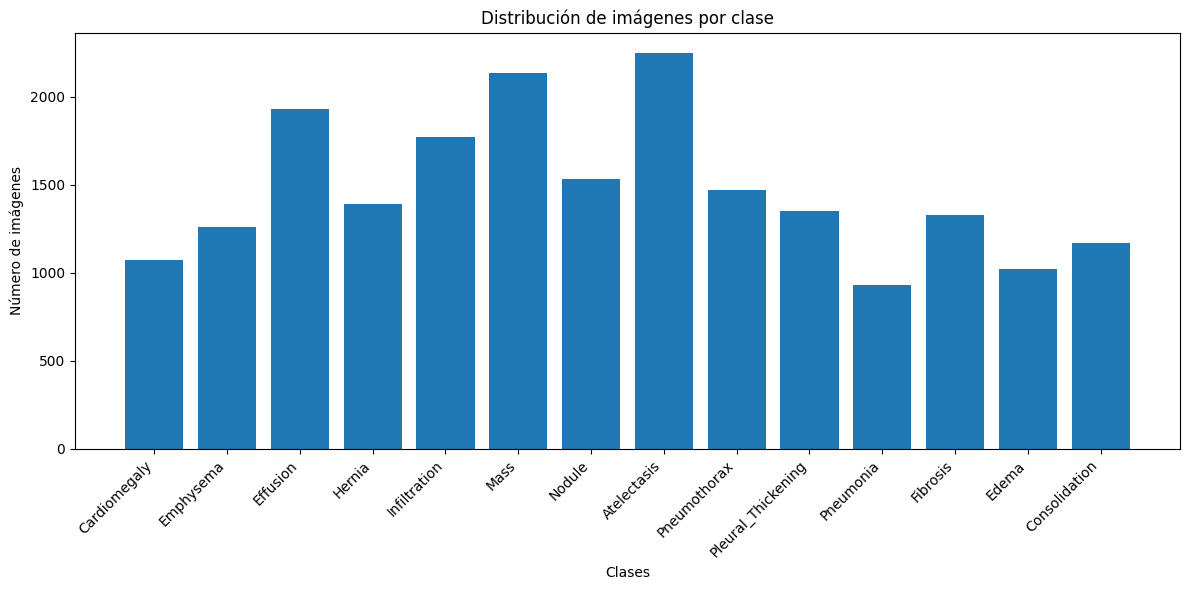

In [16]:
import matplotlib.pyplot as plt

# Obtén la frecuencia de cada clase en tu conjunto de datos
class_counts = train_df[labels].sum(axis=0)  # labels es la lista de clases, ej. ['Cardiomegaly', 'Emphysema', ...]

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de la figura si es necesario
plt.bar(class_counts.index, class_counts.values)
plt.title('Distribución de imágenes por clase')
plt.xlabel('Clases')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45, ha='right')  # Rota las etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Ajusta el diseño para evitar superposiciones
plt.show()

In [17]:
import os
import shutil
from google.colab import drive
import zipfile

# Monta tu Google Drive
drive.mount('/content/drive')

# Define la ruta donde quieres guardar el archivo comprimido
ruta_guardar = '/content/drive/MyDrive/datos_procesados.zip'  # Cambia la ruta si lo deseas

# Crea un directorio temporal para almacenar los archivos antes de comprimirlos
dir_temporal = '/content/datos_procesados_tmp'
os.makedirs(dir_temporal, exist_ok=True)

# Guarda los DataFrames modificados en el directorio temporal
train_df.to_csv(os.path.join(dir_temporal, 'train_df.csv'), index=False)
val_df.to_csv(os.path.join(dir_temporal, 'val_df.csv'), index=False)
test_df.to_csv(os.path.join(dir_temporal, 'test_df.csv'), index=False)

# Copia las imágenes modificadas al directorio temporal
img_dir = 'images'  # Directorio donde se encuentran las imágenes modificadas
shutil.copytree(img_dir, os.path.join(dir_temporal, img_dir))
# Crea el archivo comprimido
with zipfile.ZipFile(ruta_guardar, 'w') as zipf:
    for root, dirs, files in os.walk(dir_temporal):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), dir_temporal))

# Elimina el directorio temporal
shutil.rmtree(dir_temporal)

print("DataFrames e imágenes guardados en Google Drive en:", ruta_guardar)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrames e imágenes guardados en Google Drive en: /content/drive/MyDrive/datos_procesados.zip
